# House Prices: Improving Overfitting and Regularization

In this assessment, we'll continue working with the houseprices data. To complete this assessment, we will perform the following tasks:

- Load the houseprices data from Thinkful's database.
- Reimplement your model from the previous lesson.
- Try OLS, lasso, ridge, and elastic net regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?



First, we load the houseprices data from the database and import relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sqlalchemy import create_engine, text

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_price_df = pd.read_sql_query(text('SELECT * FROM houseprices'), con=engine.connect())

# No need for an open connection, because you're only doing a single query
engine.dispose()

In [2]:
house_price_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In a previous lesson we found that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the sale price. Therefore, we will turn them into dummy variables.

In [3]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

 We previous found that we can improve the model by increasing the goodness of fit. To do this, we execute the steps below:

- We first log transform the dependent variable. Recall from the histogram above that the `saleprice` variable is not normally distributed, so log transforming may help in this regard. To this end, we apply `log(1+x)` transformation of NumPy.
- Second, we create another variable by summing up the basement, first and the second floor areas.
- Third, we add the interaction of the total area and the overall quality of the house.
- Fourth, we drop the explanatory variable that aren't statistically significant.

In [4]:
house_price_df2 = house_price_df.copy()
unwanted_features = ['mszoning_FV','mszoning_RH',
                     'mszoning_RM','street_Pave',
                    'utilities_NoSeWa','salecondition_AdjLand',
                    'salecondition_Alloca','salecondition_Family']
dummy_column_names2 = [e for e in dummy_column_names if e not in unwanted_features]


We now estimate the model with the non-numerical features above and the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`. We also include the steps performed to increase the goodness of fit.

In [5]:
house_price_df2['totalsf'] = house_price_df2['totalbsmtsf'] + house_price_df2['firstflrsf'] + house_price_df2['secondflrsf']
house_price_df2['int_over_sf'] = house_price_df2['totalsf'] * house_price_df2['overallqual']

# Y is the target variable
Y = np.log1p(house_price_df2['saleprice'])
# X is the feature set
X = house_price_df2[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'totalsf', 'int_over_sf'] + dummy_column_names2]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

We first try OLS.

In [6]:
# Fit an OLS model using scikit-learn
lrm = LinearRegression()
results = lrm.fit(X_train, y_train)

# # Predict through OLS
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8370640295374336
-----Test set statistics-----
R-squared of the model in the test set is: 0.8297447446191157
Mean absolute error of the prediction is: 0.12583197321919848
Mean squared error of the prediction is: 0.028389323022972122
Root mean squared error of the prediction is: 0.16849131438436857
Mean absolute percentage error of the prediction is: 1.0516003019586757


We then use ridge regression to potentially decrease overfitting.

In [7]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

# Fitting a ridge regression model. Here, `alpha` is the regularization
# parameter (usually called `lambda`). As `alpha` gets larger, parameter
# shrinkage grows more pronounced.
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# Predict through ridge regression
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8370640295374336
-----Test set statistics-----
R-squared of the model on the test set is: 0.8297447446191248
Mean absolute error of the prediction is: 0.12583197321919462
Mean squared error of the prediction is: 0.028389323022970602
Root mean squared error of the prediction is: 0.16849131438436404
Mean absolute percentage error of the prediction is: 1.0516003019586435


Next, we try lasso regression.

In [8]:
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# Predict through lasso regression
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8370632745820864
-----Test set statistics-----
R-squared of the model on the test set is: 0.829757916151342
Mean absolute error of the prediction is: 0.1258302904422388
Mean squared error of the prediction is: 0.028387126727285137
Root mean squared error of the prediction is: 0.1684847967244675
Mean absolute percentage error of the prediction is: 1.051583483007887


To conclude, we test elastic net regression which combines the $L^1$ and $L^2$ norms from ridge and lasso regression.

In [9]:
elastic_cv = ElasticNetCV(alphas=alphas, cv=5)
elastic_cv.fit(X_train, y_train)

# Predict through elastic net regression
y_preds_train = elastic_cv.predict(X_train)
y_preds_test = elastic_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elastic_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.837063274581924
-----Test set statistics-----
R-squared of the model on the test set is: 0.8297579161320314
Mean absolute error of the prediction is: 0.1258302904441546
Mean squared error of the prediction is: 0.028387126730505086
Root mean squared error of the prediction is: 0.1684847967340231
Mean absolute percentage error of the prediction is: 1.0515834830206219


OLS and ridge, lasso, and elastic net regression return simialr results. It is not clear which fits our model the best. This could indicate that we are not overfitting our refined model.

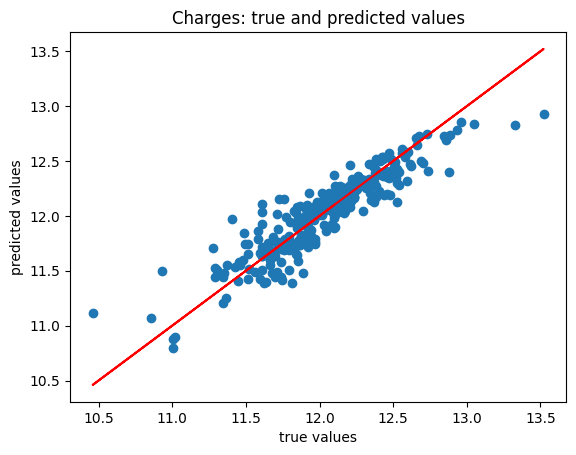

In [10]:
# We make predictions through our original OLS model
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()